#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.


### Chapter 24
**CH24A Estimating the effect of the 2010 Haiti earthquake on GDP**

using the haiti-earthquake dataset

version 0.9.0 2025-08-14

In [17]:
import os
import sys
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")
# turning off scientific notation
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [18]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/haiti-earthquake/clean/"
data_out = dirname + "da_case_studies/ch24-haiti-earthquake-gdp/"
output = dirname + "da_case_studies/ch24-haiti-earthquake-gdp/output/"

func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [19]:
# Import the prewritten helper functions
import py_helper_functions as da

# Set custom color scheme for plots
sns.set_theme(rc=da.da_theme, palette=da.color)

In [20]:
data = pd.read_stata(data_in + "haiti-earthquake-mod.dta")
# data = pd.read_stata("https://osf.io/download/h5yjm/")

In [21]:
dp_countries = [
    "Haiti",
    "Burundi",
    "Benin",
    "Burkina Faso",
    "Bangladesh",
    "Cameroon",
    "Kenya",
    "Kyrgyz Republic",
    "Cambodia",
    "Liberia",
    "Moldova",
    "Madagascar",
    "Mali",
    "Mozambique",
    "Nicaragua",
    "Nepal",
    "Rwanda",
    "Sudan",
    "Senegal",
    "Sierra Leone",
    "Togo",
    "Tanzania",
    "Uganda",
]

In [22]:
data = data.loc[lambda x: x["country"].isin(dp_countries)]

In [23]:
haiti = data.loc[lambda x: x["country"] == "Haiti", ["year", "gdptb_us"]].reset_index(
    drop=True
)

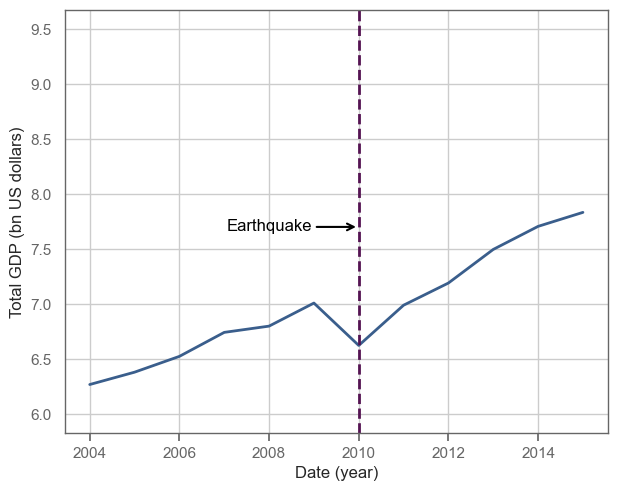

In [24]:
fig, ax = plt.subplots()

sns.lineplot(data=haiti, x="year", y="gdptb_us", linewidth=2)
plt.axvline(x=2010, color=da.color[2], linewidth=2, linestyle="--")

# Add an arrow annotation for the segment
plt.annotate(
    text="",
    xy=(2010, 7.7),
    xytext=(2009, 7.7),
    arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
)

# Add text annotation for "Earthquake"
plt.text(2008, 7.67, "Earthquake", fontsize=12, ha="center")

plt.ylabel("Total GDP (bn US dollars)", fontsize=12)
plt.xlabel("Date (year)", fontsize=12)
plt.xticks(ticks=range(2004, 2016, 2))
plt.yticks(ticks=[6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5])
plt.xlim(2004, 2015)
plt.ylim(6, 9.5)

da.add_margin(ax, 0.05, 0.05)
plt.show()

In [25]:
from pysyncon import Dataprep, Synth

In [26]:
dataprep = Dataprep(
    foo=data,
    predictors=["cons", "exp", "imp", "gcf", "land", "pop", "inf", "gdppc_w"],
    predictors_op="mean",
    special_predictors=[
        ("gdptb_us", [2005], "mean"),
        ("gdptb_us", [2007], "mean"),
        ("gdptb_us", [2009], "mean"),
    ],
    time_predictors_prior=range(2004, 2010),
    dependent="gdptb_us",
    unit_variable="country",
    time_variable="year",
    treatment_identifier="Haiti",
    controls_identifier=[c for c in dp_countries if c != "Haiti"],
    time_optimize_ssr=range(2004, 2010),
)

In [ ]:
synth = Synth()
synth.fit(
    dataprep=dataprep,
    optim_method="L-BFGS-B",
    optim_initial="equal",
    optim_options={
        "eps": 1e-4,
        "maxcor": 100,
        "maxiter": 1000,
    },
)

In [34]:
synth.weights().loc[lambda x: x != 0]

Burundi      0.396
Moldova      0.171
Madagascar   0.166
Nepal        0.267
Name: weights, dtype: float64

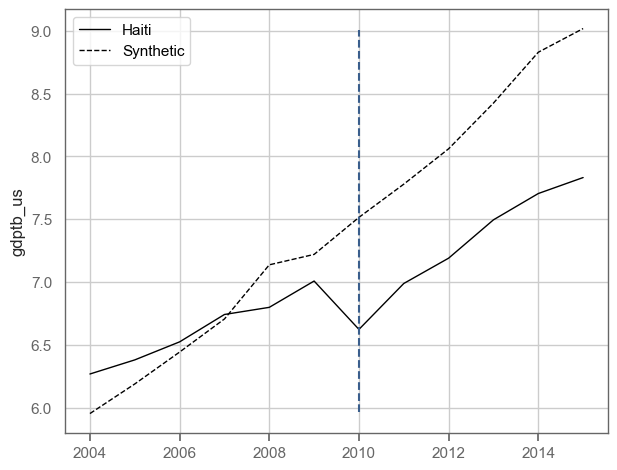

In [35]:
synth.path_plot(time_period=range(2004, 2016), treatment_time=2010)

**NOTE:** This algorithm results in a different weights for the Synthetic Haiti than Stata

Get synthetic outcomes for Haiti

In [36]:
Z0, Z1 = synth.dataprep.make_outcome_mats(time_period=range(2004, 2016))

haiti["Ysynthetic"] = synth._synthetic(Z0=Z0).values
haiti["Ytreated"] = haiti["gdptb_us"]

Figure with total GDP in Haiti and synthethic control

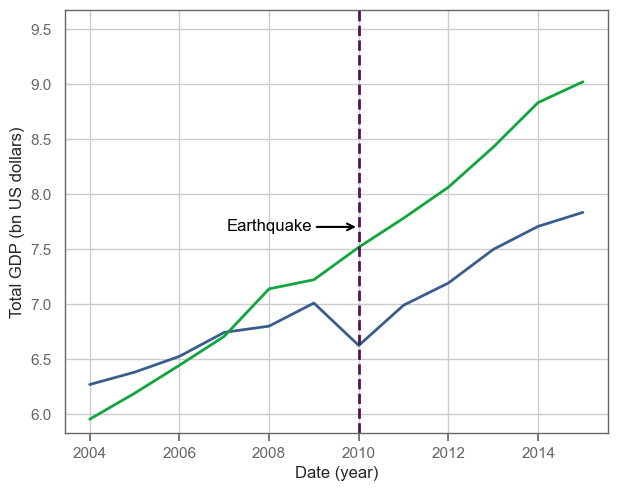

In [37]:
fig, ax = plt.subplots()

# Plot treated GDP
sns.lineplot(data=haiti, x="year", y="Ytreated", color=da.color[0], linewidth=2, ax=ax)

# Plot synthetic GDP
sns.lineplot(data=haiti, x="year", y="Ysynthetic", color=da.color[1], linewidth=2, ax=ax)

plt.axvline(x=2010, color=da.color[2], linewidth=2, linestyle="--")

# Add an arrow annotation for the segment
plt.annotate(
    text="",
    xy=(2010, 7.7),
    xytext=(2009, 7.7),
    arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
)

# Add text annotation for "Earthquake"
plt.text(2008, 7.67, "Earthquake", fontsize=12, ha="center")

plt.ylabel("Total GDP (bn US dollars)", fontsize=12)
plt.xlabel("Date (year)", fontsize=12)
plt.xticks(ticks=range(2004, 2016, 2))
plt.yticks(ticks=[6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5])
plt.xlim(2004, 2015)
plt.ylim(6, 9.5)

da.add_margin(ax, 0.05, 0.05)
plt.show()

 Figure with differenence in log total GDP

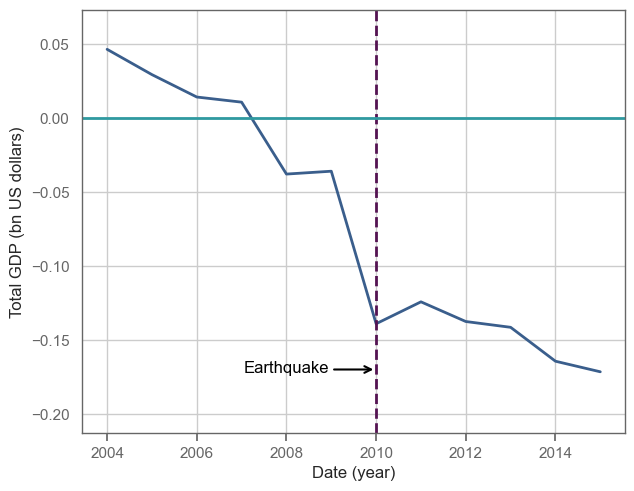

In [32]:
fig, ax = plt.subplots()

haiti["Ydiff"] = np.log(haiti["Ytreated"]) - np.log(haiti["Ysynthetic"])

# Plot treated GDP
sns.lineplot(data=haiti, x="year", y="Ydiff", color=da.color[0], linewidth=2, ax=ax)

plt.axvline(x=2010, color=da.color[2], linewidth=2, linestyle="--")
plt.axhline(y=0, color=da.color[4], linewidth=2, linestyle="-")

# Add an arrow annotation for the segment
plt.annotate(
    text="",
    xy=(2010, -0.17),
    xytext=(2009, -0.17),
    arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
)

# Add text annotation for "Earthquake"
plt.text(2008, -0.172, "Earthquake", fontsize=12, ha="center")

plt.ylabel("Total GDP (bn US dollars)", fontsize=12)
plt.xlabel("Date (year)", fontsize=12)
plt.xticks(ticks=range(2004, 2016, 2))
# plt.yticks(ticks=[6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5])
plt.xlim(2004, 2015)
plt.ylim(-0.2, 0.06)

da.add_margin(ax, 0.05, 0.05)
plt.show()